University of Stirling<br>
Computing Science and Mathematics
#### CSCU9YE - Artificial Intelligence 
## Assignment: Organising a Colour Palette 
Group : 25 Student ID : 2636161 , 2636157 , 2634926

# Multi-start hill-climbing algorithm

## Chosen Neighbourhood
The neighbourhood we decided to use was Inversion, The reason that we chose this method was because we implemented three of the different methods avaliable swap, inversion and scramble and we tested them with both instance size 100 and 500
and found that using inversion returned the lowest euclid distance for the evaluation results and we found that the colour pallete looks best when using inversion. 



## Experiments Conducted

We experimented to see how much of a difference increasing or decreasing the number of iterations had of the results of the evaluation. We found that increasing the number of iterations greatly reduces the Euclid distance meaning that the organization of the colour palette was greatly improved however, this does start to have diminishing returns as the number of iterations keeps increasing it starts to have less effect on the evaluations but the time it takes for the algorithm to complete still increases. Knowing this, we looked for a good balance between the amount and the number of iterations used effected by the evaluation and how long it would take to calculate the results. We decided that around 10000 iterations gave good results without taking very long to complete the algorithm for both instance sizes.

Another experiment that we carried out was increasing or decreasing the number of tries to see how they effected the results of the evaluation, we found that increasing the number of tries improved the results from the evaluation but not by a great amount while greatly increasing the time it takes to complete the algorithm. Therefore, we decided that 10 tries was the best option for both instance sizes.

We also compared both the number of tries and iterations using different configurations such as a low amount of tries and low amount of iterations, high amount of tries low amount of iterations, low amount of tries high iterations and high amount of tries and high amount of iterations for each of the file instance sizes. This led to the find that for both sizes the best configuration would be to use a high amount of tries and iterations to get the best result however, this takes a long time to calculate and is not much better than using a low amount of tries with a high amount of iterations. Therefore, we feel that the number of iterations has the biggest impact of the results for reducing the Euclid distance.

We experimented with different implementations of different neighbourhood mutation operators to find which one worked this best we found that for instance size 100 that inversion gave the best evaluation results and was closely followed by swap while scramble gave bad results.we also checked to see if using changing the number of tries or iterations had an effect on these while they did have an effect on improving the evaluation it didnt change which operator was the best.



## Neighbourhood Implementation

In [1]:
import random as rnd

# swap the two positions and return the index array
def swap(neig, pos1, pos2):
    neig[pos1], neig[pos2] = neig[pos2], neig[pos1]
    return neig

# invert an array between two positions
def inversion(neig, pos1, pos2):
    # account for slicing being exclusive of the terminating index
    pos2 = pos2 + 1
    # special case position 0 so that we can access the 0th index in the reverse
    if pos1 == 0:
        neig[0:pos2] = neig[(pos2-1)::-1]
    else:
        neig[pos1:pos2] = neig[(pos2-1):(pos1-1):-1]

    return neig

# shuffles part of the index array between the two specified positions (inclusive for both start 
# and end index). Uses NumPy's shuffle function for improved randomness.
def scramble(neig, pos1, pos2):
    # special case position 0 so that we can access the 0th index in the scramble
    if pos1 == 0:
        np.random.shuffle(neig[(pos2)::])
    else:
        np.random.shuffle(neig[(pos1):(pos2)])

    return neig

# Small unit test to ensure the inversion function works as expected
def test_inversion():
    test_arr = [0, 1, 2, 3, 4, 5]
    assert inversion(test_arr.copy(), 0, 3) == [3, 2, 1, 0, 4, 5]
    assert inversion(test_arr.copy(), 4, 5) == [0, 1, 2, 3, 5, 4]
    assert inversion(test_arr.copy(), 3, 5) == [0, 1, 2, 5, 4, 3]
    assert inversion(test_arr.copy(), 2, 4) == [0, 1, 4, 3, 2, 5]
    
    return "inversion unit passed"

test_inversion()

'inversion unit passed'

## Multi Hill Climbing Implementation

In [4]:
# pyplot is already imported at the start of the notebook but is left here for convinience 
import matplotlib.pyplot as plt
import random as rnd
import numpy as np      # Numerical library, used keeing the list of colours and computing the Euclidean distance

# Read in the color data file 
# Input: string with file name
# Oputput: the number of colours (integer), and a list numpy arrays with all the colours
def read_data(fname):
    cols = np.loadtxt(fname, skiprows = 4) # The first 4 lines have text information, and are ignored     
    ncols = len(cols)     # Total number of colours and list of colours
    return ncols,cols
# Dsiplay the colors as a strip of color bars
# Input: list of colors, order of colors, and height/ratio

#Select the file type instance to use
ncolors, colors = read_data("col100.txt")
    
def plot_colors(col_list, col_order, ratio = 10): 
    assert len(col_list) == len(col_order)
    img = np.zeros((ratio, len(col_list), 3))
    for i in range(0, len(col_list)):
        img[:, i, :] = col_list[col_order[i]]
    fig, axes = plt.subplots(1, figsize=(10,6)) # figsize=(width,height) handles window dimensions
    axes.imshow(img, interpolation='nearest')
    axes.axis('off')
    plt.title("Colour Palette")
    plt.show()

# Function to generate a random solution (random ordering)  - we can generate a random ordering of the list by using
# the shuffle function from the random library
def random_sol():
    sol = list(range(ncolors))   # list of consequtive numbers from 0 to ncolors
    # Shuffle the elements in the list randomly. Shuffles in place and doesn’t retunr a value
    rnd.shuffle(sol)   
    return sol

# This is an auxiliary function. It calculate the Euclidean distance between two individual colours
# Input: v and u as to be numpy arrays, vectors of real numbers with the RGB coordinates.

def euclid(v, u):
    return np.linalg.norm(v - u)

# Evaluation function.  Measures the quality of a given solution (ordering of colours) 
# The function computes the sum of the distances between all consecutive colours in the ordering
# Input: cols: list of colours 
#        ordc: ordering of colours
# Output: real number with the sumf of pair-wise differences in the colour ordering

def evaluate(cols, ordc):     
    adjacentColPairs = [[cols[ordc[i]],cols[ordc[i-1]]] for i in range(1,len(ordc))]
    return sum([euclid(i[1], i[0]) for i in adjacentColPairs])

# Random neighbour - the algorith is chosen to carry out sorting with each iteration of the hill climb
# and is the core of the solution to sorting the colour palette. The algorithm was chosen as it allows
# for continuous improvement until a near minima is reached - at which point continuing iterations wont
# yield significant improvements.
# The algorithm works by:
#     randomly selecting two random positions within the solution array (the two random neighbours)
#     swapping the two neighbours
#     evaluating the solution after the swap (if distance has reduced, this is an improvement)
#
# The random neighbour function does not itself modify the optimum solution array, the decision on whether
# to do this or not is left to the hill climbing algorithm
def random_neig(sol):
    # the neighbour array stores the randomly ordered indices
    neig = sol[:]
    # randomly select two positions to potentially swap
    pos1 = rnd.randint(0,ncolors-1)
    pos2 = rnd.randint(0,ncolors-1)
    # checks to see if the selected posistions have the same value 
    # randomly select a different position for pos2, until the two positions are different
    while (pos1 == pos2): 
        pos2 = rnd.randint(0,ncolors-1)         
    # swap the two positions and re-evaluate the euclidean distance   
    ## Select the Neighbourhood to be used to test how each one effects the evaluation and the look of the colour pallete
    
    neig = inversion(neig.copy(), pos1, pos2)
    #neig = swap(neig.copy(), pos1, pos2)
    #neig = scramble(neig.copy(), pos1, pos2)
    e1 = evaluate(colors,neig)
    
    return neig, e1

# The hill climbing algorith utilises the random neighbour function in search of the optimum solution to
# sorting the colour palette. Hill climb takes an iterative approach where witch each iteration the result
# of the random neighbour function is evaluated. If random neighbour provides a better solution and the currently
# best know one, we update our best solution and continue iterating.  
def hill_climbing(ncolours):
    # stores a record of evaluations for each iteration, used for showing improvement of evalutation with each iteration
    trace = []
    # start with random solution and try to sort indeces into a better location to reduce overall euclidean distance
    sol = random_sol()
    # show original colour palette
    print("Un-sorted colour palette")
    plot_colors(colors, sol, 80)    
    # evaluate the euclidean distance between the unsorted colour palette and the randomly generated solution
    # this evaluation is used as an initial baseline on which we will try to improve by reducing the overall euclidean distance
    # the e1 variable will store the lowest evaluation found and will be updated when an improved evaluation is found
    e1 = evaluate(colors, sol)
    trace.append(e1)
    # iterate over the range of indeces
    for i in range (ncolours):
        # get a random neigbour and compare if after the indeces are swapped, we get a better solution (lower evaluation value)
        sol1, e2 = random_neig(sol)
        # if the evaluation value is lower after the swap then persist the swap in our solution array and update the best solution so far (e1)
        if e2 < e1:
            e1 = e2
            sol = sol1[:]
            trace.append(e1)
    
    return sol, e1, trace
       
# A multi-start of the hill climb meaning we run several iterations of the
# hill climbing algorithm. 
def multi_climbing(tries, iterator):
    bSol = []
    bEval = 0   
    # iterate for the number of given tries
    for i in range(tries):
        sol, e1, trace = hill_climbing(iterator)
        if(e1 < bEval or bEval == 0):
            bEval = e1
            bSol = sol[:]
            
        return bSol, bEval, trace

## Run the multi-start hill climb and visualise the best solution for instance 100

Un-sorted colour palette


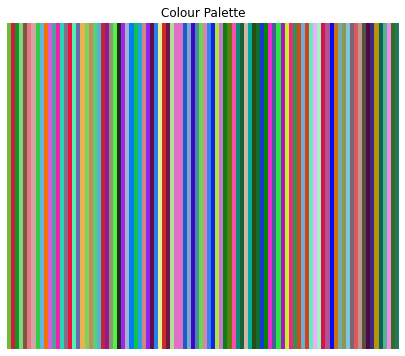

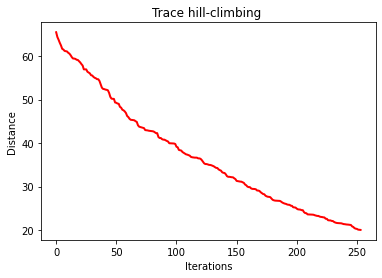

Solution colour palette for instance 100


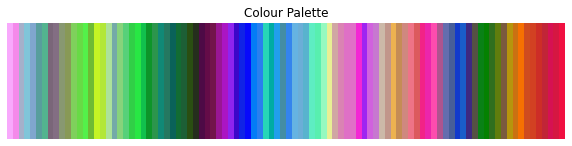

[74, 49, 94, 84, 78, 4, 85, 58, 75, 86, 69, 38, 52, 67, 47, 16, 77, 88, 61, 26, 21, 68, 29, 76, 14, 40, 7, 13, 20, 36, 53, 56, 5, 17, 32, 92, 8, 2, 15, 3, 64, 73, 6, 80, 30, 45, 43, 9, 60, 37, 50, 28, 87, 90, 65, 1, 27, 39, 55, 23, 19, 82, 48, 22, 62, 71, 34, 42, 41, 11, 95, 81, 93, 66, 79, 57, 59, 89, 63, 83, 70, 33, 12, 25, 91, 10, 54, 31, 0, 24, 72, 18, 46, 44, 51, 35]
Evaluation Result for Instance 100 : 20.03830764190883


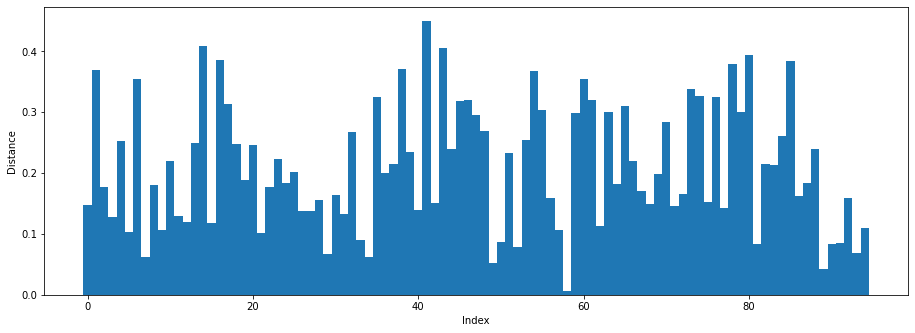

Best solution colour palette for instance 100


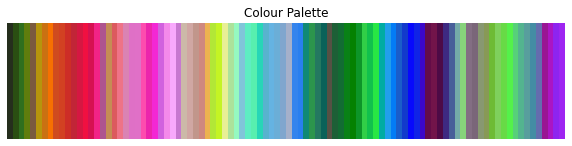

Best Evaluation Result for Instance 100 : 19.01541528480078


In [3]:
mhc_result100, mhc_Eval100, trace = multi_climbing(10,10000)            

# Display a graph of the trace
plt.figure()
plt.plot(trace,color="red", linewidth=2)
plt.title("Trace hill-climbing ")
plt.ylabel("Distance")
plt.xlabel("Iterations")
plt.show()

# visualise the solution colour palette
print("Solution colour palette for instance 100")
plot_colors(colors, mhc_result100, 20)
print(mhc_result100)
print("Evaluation Result for Instance 100 :",mhc_Eval100)

# visualise the distance between each colour in the best solution
# showcases the biggest gap's location relating to its index location
distance = []
for i in range(0, ncolors-1):
    distance.append(euclid(colors[mhc_result100[i]], colors[mhc_result100[i+1]]))
fig = plt.figure()
ax = fig.add_axes([0,1,2,1])
indices = range(0, ncolors-1)
ax.bar(indices, distance, width=1)
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

# visualise the best solution colour palette
mhc_best100 = [5, 56, 25, 91, 10, 54, 31, 0, 24, 72, 18, 46, 51, 35, 44, 81, 79, 42, 95, 11, 39, 55, 23, 66, 93, 19, 48, 49, 74, 22, 62, 27, 71, 41, 34, 77, 16, 1, 88, 65, 84, 87, 90, 30, 28, 37, 50, 78, 94, 60, 80, 7, 40, 13, 20, 70, 53, 36, 33, 12, 14, 68, 76, 29, 45, 43, 6, 63, 89, 73, 64, 3, 32, 92, 17, 83, 59, 61, 26, 75, 58, 86, 69, 47, 38, 52, 67, 21, 85, 4, 9, 57, 8, 2, 15, 82]
print("Best solution colour palette for instance 100")
plot_colors(colors, mhc_best100, 20)
mhc_bestEval100 = evaluate(colors, mhc_best100)
print("Best Evaluation Result for Instance 100 :",mhc_bestEval100)




## Run the multi-start hill climb and visualise the best solution for instance 500

Un-sorted colour palette


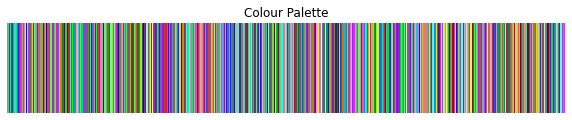

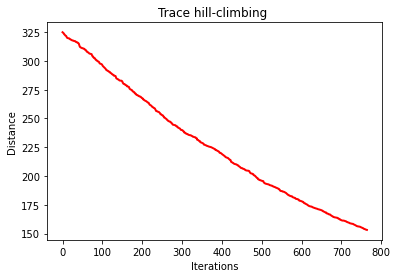

Solution colour palette for instance 500


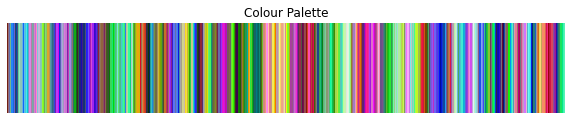

[264, 249, 57, 493, 354, 168, 292, 456, 179, 439, 339, 169, 140, 37, 403, 451, 408, 150, 459, 373, 472, 271, 61, 186, 111, 48, 166, 84, 309, 390, 145, 189, 301, 431, 26, 38, 412, 185, 4, 313, 215, 59, 109, 320, 438, 478, 64, 207, 176, 94, 269, 151, 22, 447, 117, 78, 366, 244, 139, 13, 449, 171, 343, 155, 466, 253, 126, 374, 319, 334, 218, 331, 127, 318, 491, 425, 82, 3, 153, 327, 287, 388, 297, 474, 329, 105, 147, 190, 416, 462, 258, 314, 342, 194, 420, 188, 85, 21, 107, 238, 259, 146, 386, 97, 256, 80, 350, 88, 375, 364, 409, 481, 476, 119, 201, 328, 99, 173, 358, 368, 42, 363, 24, 18, 338, 430, 208, 210, 280, 305, 263, 304, 470, 395, 170, 54, 278, 414, 177, 220, 243, 255, 242, 489, 355, 15, 333, 308, 371, 160, 236, 60, 441, 9, 494, 265, 154, 62, 252, 302, 310, 429, 262, 68, 445, 30, 6, 246, 324, 56, 5, 17, 156, 392, 214, 142, 237, 434, 254, 228, 267, 284, 231, 187, 455, 116, 158, 336, 295, 211, 247, 115, 384, 480, 490, 2, 433, 464, 345, 52, 421, 129, 484, 453, 102, 291, 12, 357, 183,

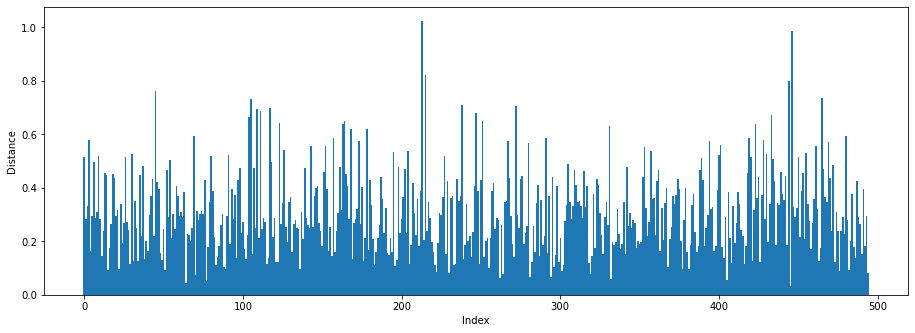

Best solution colour palette for instance 500


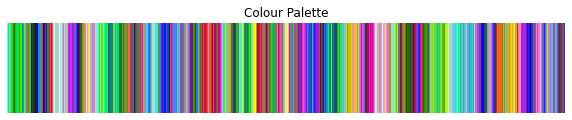

Best Evaluation Result for Instance 500 : 149.0032583802829


In [5]:
mhc_result500, mhc_Eval500, trace = multi_climbing(10,10000)            

# Display a graph of the trace
plt.figure()
plt.plot(trace,color="red", linewidth=2)
plt.title("Trace hill-climbing ")
plt.ylabel("Distance")
plt.xlabel("Iterations")
plt.show()

# visualise the best solution colour palette
print("Solution colour palette for instance 500")
plot_colors(colors, mhc_result500, 80)
print(mhc_result500)
print("Evaluation Result for Instance 500 : ",mhc_Eval500)

# visualise the distance between each colour in the best solution
# showcases the biggest gap's location relating to its index location
distance = []
for i in range(0, ncolors-1):
    distance.append(euclid(colors[mhc_result500[i]], colors[mhc_result500[i+1]]))
fig = plt.figure()
ax = fig.add_axes([0,1,2,1])
indices = range(0, ncolors-1)
ax.bar(indices, distance, width=1)
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()


# visualise the best solution colour palette
mhc_best500 = [448, 30, 375, 267, 476, 159, 12, 420, 337, 378, 152, 428, 129, 284, 45, 26, 493, 436, 440, 119, 124, 365, 56, 5, 430, 270, 208, 224, 80, 9, 353, 329, 102, 126, 439, 466, 433, 325, 294, 44, 443, 330, 311, 409, 367, 273, 495, 405, 398, 212, 366, 154, 309, 94, 193, 478, 355, 438, 427, 15, 323, 109, 73, 17, 453, 291, 462, 304, 42, 298, 359, 166, 404, 344, 350, 226, 387, 463, 131, 107, 130, 261, 132, 301, 52, 296, 413, 125, 29, 194, 419, 13, 216, 316, 21, 238, 360, 188, 364, 272, 33, 25, 277, 389, 414, 116, 400, 139, 482, 255, 239, 121, 59, 253, 222, 183, 345, 190, 217, 248, 426, 111, 417, 61, 451, 486, 168, 114, 181, 128, 481, 120, 492, 145, 487, 313, 354, 320, 218, 246, 315, 136, 380, 179, 148, 300, 276, 232, 236, 43, 60, 146, 50, 214, 204, 240, 160, 86, 483, 27, 39, 381, 391, 454, 479, 464, 262, 171, 403, 210, 85, 282, 10, 35, 24, 471, 358, 137, 275, 108, 95, 444, 195, 257, 332, 147, 105, 467, 442, 251, 151, 90, 198, 339, 189, 149, 142, 317, 473, 470, 231, 53, 319, 36, 349, 263, 87, 340, 279, 283, 235, 40, 485, 307, 165, 322, 352, 415, 113, 377, 290, 54, 141, 156, 51, 72, 410, 489, 249, 158, 460, 242, 234, 187, 449, 431, 348, 123, 133, 75, 446, 245, 411, 271, 418, 157, 293, 1, 138, 437, 445, 370, 244, 458, 135, 79, 406, 474, 457, 333, 196, 447, 19, 48, 394, 384, 230, 371, 452, 266, 274, 326, 63, 64, 327, 469, 2, 164, 343, 70, 336, 374, 6, 346, 305, 281, 200, 7, 38, 393, 215, 161, 456, 96, 174, 76, 335, 178, 110, 37, 140, 237, 201, 99, 328, 434, 288, 299, 162, 34, 175, 185, 77, 100, 144, 396, 199, 57, 351, 32, 388, 172, 93, 490, 286, 117, 472, 303, 202, 250, 62, 41, 385, 382, 180, 106, 461, 372, 11, 71, 395, 229, 169, 241, 219, 228, 259, 254, 58, 92, 220, 455, 243, 98, 91, 357, 314, 155, 264, 416, 258, 268, 209, 8, 356, 89, 153, 197, 81, 376, 435, 14, 484, 177, 334, 361, 112, 429, 170, 421, 256, 342, 68, 432, 379, 321, 67, 47, 278, 122, 16, 221, 143, 88, 163, 488, 84, 150, 225, 97, 118, 386, 184, 459, 223, 4, 475, 390, 227, 176, 422, 369, 280, 408, 383, 65, 66, 402, 233, 192, 134, 3, 477, 203, 83, 341, 20, 186, 494, 465, 22, 247, 318, 362, 338, 46, 363, 0, 31, 423, 368, 312, 69, 424, 289, 310, 205, 397, 252, 173, 399, 302, 412, 18, 401, 260, 49, 480, 491, 115, 82, 211, 441, 331, 468, 347, 308, 324, 207, 103, 104, 425, 23, 285, 74, 269, 101, 407, 127, 265, 182, 450, 55, 373, 191, 292, 295, 78, 28, 297, 167, 392, 206, 213, 306, 287]
print("Best solution colour palette for instance 500")
plot_colors(colors, mhc_best500, 80)
mhc_bestEval500 = evaluate(colors, mhc_best500)
print("Best Evaluation Result for Instance 500 :",mhc_bestEval500)